In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required libaries

In [ ]:
import pandas as pd 
import numpy as np
import math

In [ ]:
feature_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","target","severity"]

Loading train and test data

In [ ]:
train_df = pd.read_csv("/content/drive/Shareddrives/kdd dataset/KDDTrain+.txt",sep=",", names=feature_names)
test_df = pd.read_csv("/content/drive/Shareddrives/kdd dataset/KDDTest+.txt",sep=",",names=feature_names)
train_df.drop(['severity'],axis=1,inplace=True)
test_df.drop(['severity'],axis=1,inplace=True)

In [ ]:
train_attacks_list=set(train_df['target'])
print(train_attacks_list)

{'nmap', 'spy', 'pod', 'loadmodule', 'neptune', 'smurf', 'multihop', 'rootkit', 'buffer_overflow', 'satan', 'warezmaster', 'portsweep', 'warezclient', 'ipsweep', 'perl', 'land', 'imap', 'ftp_write', 'phf', 'guess_passwd', 'teardrop', 'normal', 'back'}


In [ ]:
len(train_attacks_list)

23

In [ ]:
test_attacks_list=set(test_df['target'])
print(test_attacks_list)

{'nmap', 'sendmail', 'pod', 'processtable', 'snmpgetattack', 'loadmodule', 'named', 'neptune', 'xlock', 'smurf', 'multihop', 'saint', 'xsnoop', 'mscan', 'buffer_overflow', 'worm', 'rootkit', 'satan', 'warezmaster', 'httptunnel', 'portsweep', 'xterm', 'udpstorm', 'ipsweep', 'mailbomb', 'perl', 'snmpguess', 'apache2', 'land', 'imap', 'ftp_write', 'phf', 'guess_passwd', 'ps', 'teardrop', 'normal', 'back', 'sqlattack'}


In [ ]:
new_attack_list=[-1]*test_df.shape[0]
count_new_attacks=0

In [ ]:
for i,row in test_df.iterrows():
  if test_df['target'][i] not in train_attacks_list:
    new_attack_list[i]=1
    count_new_attacks+=1

In [ ]:
pd.DataFrame(new_attack_list).to_csv("/content/drive/Shareddrives/kdd dataset/new_attack_list.csv",index=False)

In [ ]:
len(test_attacks_list)

38

In [ ]:
binary_target=pd.DataFrame(train_df['target'].map(lambda x:'normal' if x=='normal' else 'attack'))
binary_target['target'].value_counts()

normal    67343
attack    58630
Name: target, dtype: int64

In [ ]:
train_df['target']=binary_target

In [ ]:
binary_target_test=pd.DataFrame(test_df['target'].map(lambda x:'normal' if x=='normal' else 'attack'))
binary_target_test['target'].value_counts()

attack    12833
normal     9711
Name: target, dtype: int64

In [ ]:
test_df['target']=binary_target_test

In [ ]:
import lightgbm as lgb

In [ ]:
train_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder 

In [ ]:
cat_features=['protocol_type','flag']

cat_df=train_df[cat_features]

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'service' column 
encoder_df = pd.DataFrame(encoder.fit_transform(train_df[['service']]).toarray())

In [ ]:
encoder_df_test=pd.DataFrame(encoder.transform(test_df[['service']]).toarray())

In [ ]:
cat_df=pd.get_dummies(cat_df,columns=cat_features)
cat_df=cat_df.join(encoder_df)
cat_df.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,...,60,61,62,63,64,65,66,67,68,69
0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cat_df_test=test_df[cat_features]
cat_df_test=pd.get_dummies(cat_df_test,columns=cat_features)
cat_df_test=cat_df_test.join(encoder_df_test)
cat_df_test.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,...,60,61,62,63,64,65,66,67,68,69
0,0,1,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
numeric_cols=train_df.select_dtypes(include='number').columns

In [ ]:
train_df=train_df[numeric_cols].join(cat_df)
train_df['target']=binary_target

In [ ]:
test_df=test_df[numeric_cols].join(cat_df_test)
test_df['target']=binary_target_test

Training the model using lightgbm method from python API

In [ ]:
lgb_model= lgb.LGBMClassifier(objective='binary',boosting_type='gbdt',learning_rate=0.01,bagging_fraction=0.5,is_unbalance=True)

In [ ]:
X_train=train_df.loc[:,train_df.columns!='target']
y_train=train_df['target']
X_test=test_df.loc[:,test_df.columns!='target']
y_test=test_df['target']

In [ ]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.5, is_unbalance=True, learning_rate=0.01,
               objective='binary')

Model predictions for test data

In [ ]:
test_df['preds']=lgb_model.predict(X_test)

In [ ]:
test_df['match']=(test_df['target']==test_df['preds'])

In [ ]:
test_df['match'].mean()

0.7619322214336409

%new attacks detected

In [ ]:
new_attacks_detected=(test_df['match']==new_attack_list)
print("number of new_attacks in test set",count_new_attacks)
print("number of new_attacks detected",sum(new_attacks_detected))

number of new_attacks in test set 3750
number of new_attacks detected 1365


In [ ]:
print("percent of new attacks detected",sum(new_attacks_detected)/count_new_attacks)

percent of new attacks detected 0.364


Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

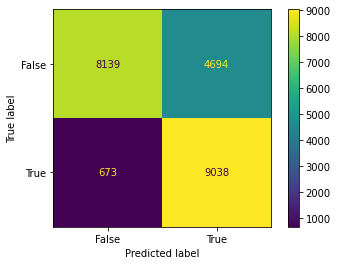

In [ ]:
confusion_matrix = metrics.confusion_matrix(test_df['target'], test_df['preds'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
np.savetxt("/content/drive/Shareddrives/kdd dataset/lightgbm_bin_confusion_mat",confusion_matrix)

In [ ]:
precision=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[0][1])
print("precision:")
print(precision)

precision:
0.6581706961840955


In [ ]:
recall=(confusion_matrix[1][1])/(confusion_matrix[1][0]+confusion_matrix[1][1])
print("recall")
print(recall)

recall
0.9306971475646174


In [ ]:
accuracy=(confusion_matrix[1][1]+confusion_matrix[0][0])/sum(sum(confusion_matrix))
print("accuracy:")
print(accuracy)

accuracy:
0.7619322214336409


Saving new_attack details in test_data

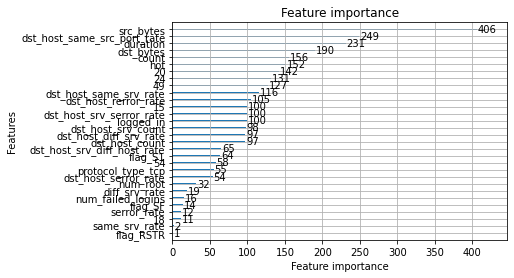

In [ ]:
lgb.plot_importance(lgb_model)